In [1]:
import xlrd
from pathlib import Path
import pandas as pd
import numpy as np
from numba import decorators
import librosa

import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
# read in the data file
# Give the location of the file 

df = pd.read_excel(r'data/data.xlsx', sheet_name='normalized')
# print(df)

In [6]:
## LOADING IN DATASETS

dataset = Path.cwd().joinpath("SongEmotionDataset")
datasheet = Path.cwd().joinpath("data") # for csua
imagepath = Path.cwd().joinpath("SongEmotionDatasetImages")
cmap = plt.get_cmap('inferno')

#emotion labels
label_loc = datasheet.joinpath("data.xlsx")
wb = xlrd.open_workbook(label_loc) 
sheet = wb.sheet_by_index(3)

#emotion arr
# emotions = ["amazement", "calmness", "power", "joyful activation", "sadness"]
emotions = ["solemnity", "tenderness", "nostalgia", "calmness", "power", "joyful activation", "tension", "sadness"]

/Users/carlyzfeng/launchpad/memories/venv/lib/python3.8/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/carlyzfeng/launchpad/memories/venv/lib/python3.8/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/carlyzfeng/launchpad/memories/venv/lib/python3.8/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/carlyzfeng/launchpad/memories/venv/lib/python3.8/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/carlyzfeng/launchpad/memories/venv/lib/python3.8/site-packages/librosa/core/audio.py:161: UserWarning: PySoun

KeyboardInterrupt: 

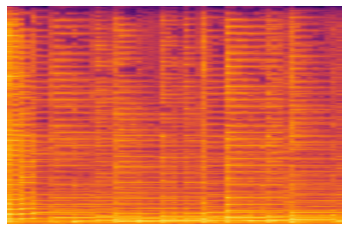

In [5]:


def saveimages():
    song = []
    for filename in os.listdir(dataset):
        if filename.endswith(".mp3"):
            songname = dataset.joinpath(filename)
            y, sr = librosa.load(songname, mono=True, duration=5)
            plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
            plt.axis('off');
            plt.savefig(imagepath.joinpath(filename.replace(".mp3", ".png")))
            plt.clf()

saveimages()

In [7]:
train_percentage = 0.8

train_song = []
test_song = []
train_img = []
test_img = []
train_emotion = []
test_emotion = []

row_indexes = np.arange(1,226)
np.random.shuffle(row_indexes)

def get_data(indexes):
    print(indexes)
    song = []
    img = []
    emotion = []
    
    for x in indexes:
        row = int(sheet.cell_value(x, 13) - 1)
        trackid = int(sheet.cell_value(x, 0))
        song.append(dataset.joinpath("{}.mp3".format(trackid)))
        img.append(imagepath.joinpath("{}.png".format(trackid)))
        emotion.append(row)
            
    return song, img, emotion
    
song, img, emotion = get_data(row_indexes)

train_song = [song[i] for i in range(len(song)) if i < len(song)*train_percentage]
test_song = [song[i] for i in range(len(song)) if i >= len(song)*train_percentage]

train_img = [img[i] for i in range(len(img)) if i < len(img)*train_percentage]
test_img = [img[i] for i in range(len(img)) if i >= len(img)*train_percentage]

train_emotion = [emotion[i] for i in range(len(emotion)) if i < len(emotion)*train_percentage]
test_emotion = [emotion[i] for i in range(len(emotion)) if i >= len(emotion)*train_percentage]

[  1  95 156  22  79  90 134 176 133 116 121  68  78 105  88 137 218 164
  83   7  60 148  17 213 209  14  53 203 204 225 150 181  36 169  70  81
  96  97  76 214 114 107  16  66 142 123 110 152 147 194 117 130 183 131
  94 199 170  61  13  86 158 160  18  93 109  38 180 154 119  59  73 190
  85 145 188 168 167  92 202  15  50 175 200 182 211 223 132  27 124 171
 122  40  54 191 174 172 112  30 143  55  33  42  62 113  24   2 220 103
 106 140   5  71 149 208 126 136  12  23 159 216 120 161  65 165  99   4
 128 196 162 166  87  35  49 205  34 186  29  80 125  82 141  63  39 100
  56 111  21 197 222  52  28 129 179  67 151  25 104 177  89 192 189 207
 195  77   8 101 102 193  20  46  11   3 108 212 144 187 157 118  43 163
  51  41  47  37  48  10  45  26 210 115 173  19 184  98  64 198  58 201
  75 185  74  69  84  91 155 206 139 127 138 219 217 221  44 178  57 153
   9 135 224  72 146 215  31   6  32]


In [8]:
# train_emotion

In [9]:
class SongEmotionDataset(Dataset):
    """
    Song Emotion Dataset. Uses librosa to process mp3 files.
    Takes first 20 seconds, and samples every 10 to get processed audio tensor.
    """

    def __init__(self, png, labels, transform=None):
        """
        Args:
            mp3: list of paths to mp3 files
            labels: list of labels
        """
        self.labels = labels
        self.png = png
        self.cache = {}
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        if index not in self.cache.keys():
            transform = transforms.Compose([
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]
            )

            songimage = Image.open(self.png[index]).convert('RGB')
            songimage = transform(songimage)
            self.cache[index] = (songimage, torch.tensor(self.labels[index], device=device))
            
        return self.cache[index]

In [10]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
# don't freeze model
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(emotions))
model_conv = model_conv.to(device)
            
model = model_conv
model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/carlyzfeng/.cache/torch/checkpoints/resnet50-19c8e357.pth
99.2%

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
train_set = SongEmotionDataset(train_img, train_emotion)
test_set = SongEmotionDataset(test_img, test_emotion)
print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))

kwargs = {'num_workers': 2, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 16, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 16, shuffle = True, **kwargs)

optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.0001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

Train set size: 180
Test set size: 45


In [21]:
def train(model, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
#         output = output.requires_grad_() #set requires_grad to True for training
        loss = F.cross_entropy(output, target)
        
        loss.backward()
        optimizer.step()
        
#         print("target: " + str(target))
#         print("output: " + str(output))
#         print("\n")
        
        if batch_idx % log_interval == 0: #print training stats
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss))

In [24]:
def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        output = model(data)
        
#         print(output)
#         output = output.permute(1, 0, 2)
        pred = output.max(1)[1] # get the index of the max log-probability 
        print(pred)
        correct += pred.eq(target).sum()
        print(correct)
#         correct += pred.eq(target.max(1)[1]).cpu().sum().item()
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [25]:
import warnings

log_interval = 5
warnings.filterwarnings("ignore")
for epoch in range(1, 100):
    print("training epoch " + str(epoch))
    if epoch == 31:
        print("First round of training complete. Setting learn rate to 0.001.")
#     scheduler.step()
    train(model, epoch)
    scheduler.step()
    test(model, epoch)

training epoch 1
Train Epoch: 1 [0/180 (0%)]	Loss: 2.550809
Train Epoch: 1 [40/180 (22%)]	Loss: 2.424289
Train Epoch: 1 [80/180 (43%)]	Loss: 4.862367
Train Epoch: 1 [120/180 (65%)]	Loss: 2.952238
Train Epoch: 1 [160/180 (87%)]	Loss: 1.901950
tensor([5, 3, 3, 5, 3, 2, 4, 5])
tensor(0)
tensor([5, 3, 5, 5, 5, 5, 3, 5])
tensor(0)
tensor([4, 5, 3, 5, 4, 3, 4, 5])
tensor(2)
tensor([3, 4, 5, 5, 3, 5, 4, 5])
tensor(3)
tensor([4, 4, 5, 3, 3, 5, 4, 3])
tensor(4)
tensor([3, 5, 5, 4, 4])
tensor(6)

Test set: Accuracy: 6/45 (13%)

training epoch 2
Train Epoch: 2 [0/180 (0%)]	Loss: 4.452451
Train Epoch: 2 [40/180 (22%)]	Loss: 1.543056
Train Epoch: 2 [80/180 (43%)]	Loss: 1.231506
Train Epoch: 2 [120/180 (65%)]	Loss: 2.836143
Train Epoch: 2 [160/180 (87%)]	Loss: 1.782306
tensor([4, 4, 4, 6, 4, 4, 6, 5])
tensor(1)
tensor([6, 4, 4, 6, 4, 6, 6, 4])
tensor(3)
tensor([6, 6, 4, 6, 4, 4, 6, 6])
tensor(4)
tensor([4, 5, 5, 6, 5, 6, 4, 4])
tensor(5)
tensor([6, 6, 6, 4, 4, 6, 5, 6])
tensor(5)
tensor([6, 4, 6, 4,

tensor([6, 4, 1, 4, 4, 0, 1, 1])
tensor(4)
tensor([5, 4, 4, 3, 0, 6, 4, 6])
tensor(4)
tensor([4, 4, 4, 5, 1, 4, 5, 5])
tensor(6)
tensor([4, 4, 5, 6, 4])
tensor(7)

Test set: Accuracy: 7/45 (16%)

training epoch 17
Train Epoch: 17 [0/180 (0%)]	Loss: 1.151056
Train Epoch: 17 [40/180 (22%)]	Loss: 0.603072
Train Epoch: 17 [80/180 (43%)]	Loss: 1.176369
Train Epoch: 17 [120/180 (65%)]	Loss: 1.018737
Train Epoch: 17 [160/180 (87%)]	Loss: 0.295323
tensor([5, 4, 0, 7, 1, 0, 1, 0])
tensor(3)
tensor([3, 5, 1, 5, 5, 1, 1, 1])
tensor(5)
tensor([0, 5, 5, 7, 7, 5, 1, 0])
tensor(7)
tensor([4, 7, 7, 0, 5, 0, 4, 5])
tensor(7)
tensor([5, 1, 0, 5, 1, 5, 7, 3])
tensor(7)
tensor([0, 3, 1, 1, 7])
tensor(9)

Test set: Accuracy: 9/45 (20%)

training epoch 18
Train Epoch: 18 [0/180 (0%)]	Loss: 0.569109
Train Epoch: 18 [40/180 (22%)]	Loss: 0.357747
Train Epoch: 18 [80/180 (43%)]	Loss: 1.419103
Train Epoch: 18 [120/180 (65%)]	Loss: 0.779374
Train Epoch: 18 [160/180 (87%)]	Loss: 0.617843
tensor([7, 4, 3, 2, 7, 7, 

Train Epoch: 32 [0/180 (0%)]	Loss: 0.373924
Train Epoch: 32 [40/180 (22%)]	Loss: 0.690275
Train Epoch: 32 [80/180 (43%)]	Loss: 0.146072
Train Epoch: 32 [120/180 (65%)]	Loss: 0.489100
Train Epoch: 32 [160/180 (87%)]	Loss: 0.175663
tensor([3, 3, 2, 3, 7, 6, 5, 4])
tensor(3)
tensor([5, 1, 6, 5, 2, 5, 0, 1])
tensor(6)
tensor([2, 6, 7, 7, 3, 0, 1, 4])
tensor(7)
tensor([2, 0, 4, 0, 2, 1, 5, 6])
tensor(9)
tensor([4, 4, 7, 2, 4, 3, 1, 1])
tensor(10)
tensor([6, 4, 3, 6, 4])
tensor(10)

Test set: Accuracy: 10/45 (22%)

training epoch 33
Train Epoch: 33 [0/180 (0%)]	Loss: 0.314543
Train Epoch: 33 [40/180 (22%)]	Loss: 0.330863
Train Epoch: 33 [80/180 (43%)]	Loss: 0.204418
Train Epoch: 33 [120/180 (65%)]	Loss: 0.204935
Train Epoch: 33 [160/180 (87%)]	Loss: 0.297035
tensor([6, 3, 5, 2, 7, 2, 2, 3])
tensor(1)
tensor([2, 3, 6, 0, 4, 4, 6, 2])
tensor(1)
tensor([0, 6, 2, 5, 5, 2, 2, 5])
tensor(3)
tensor([0, 3, 6, 2, 0, 7, 2, 1])
tensor(3)
tensor([2, 7, 3, 0, 0, 6, 5, 0])
tensor(5)
tensor([5, 2, 1, 7, 6]

tensor([7, 6, 2, 2, 3, 0, 3, 0])
tensor(1)
tensor([3, 1, 2, 0, 5, 5, 2, 4])
tensor(3)
tensor([6, 6, 7, 6, 5, 1, 4, 6])
tensor(5)
tensor([4, 0, 4, 3, 7, 2, 7, 7])
tensor(7)
tensor([6, 1, 5, 4, 5])
tensor(9)

Test set: Accuracy: 9/45 (20%)

training epoch 48
Train Epoch: 48 [0/180 (0%)]	Loss: 0.517532
Train Epoch: 48 [40/180 (22%)]	Loss: 0.312093
Train Epoch: 48 [80/180 (43%)]	Loss: 0.044193
Train Epoch: 48 [120/180 (65%)]	Loss: 0.069151
Train Epoch: 48 [160/180 (87%)]	Loss: 0.076963
tensor([4, 0, 7, 5, 4, 6, 3, 5])
tensor(2)
tensor([2, 6, 0, 7, 7, 5, 1, 0])
tensor(4)
tensor([6, 5, 3, 4, 2, 4, 3, 2])
tensor(4)
tensor([2, 7, 3, 5, 5, 7, 4, 6])
tensor(5)
tensor([1, 3, 5, 0, 1, 7, 4, 1])
tensor(7)
tensor([3, 6, 6, 0, 0])
tensor(7)

Test set: Accuracy: 7/45 (16%)

training epoch 49
Train Epoch: 49 [0/180 (0%)]	Loss: 0.040043
Train Epoch: 49 [40/180 (22%)]	Loss: 0.123181
Train Epoch: 49 [80/180 (43%)]	Loss: 0.031702
Train Epoch: 49 [120/180 (65%)]	Loss: 0.373927
Train Epoch: 49 [160/180 (87%)

Train Epoch: 63 [0/180 (0%)]	Loss: 0.158673
Train Epoch: 63 [40/180 (22%)]	Loss: 0.045894
Train Epoch: 63 [80/180 (43%)]	Loss: 0.331613
Train Epoch: 63 [120/180 (65%)]	Loss: 0.321173
Train Epoch: 63 [160/180 (87%)]	Loss: 0.060116
tensor([1, 3, 6, 5, 3, 2, 7, 7])
tensor(1)
tensor([7, 2, 6, 4, 5, 3, 4, 0])
tensor(2)
tensor([0, 1, 2, 6, 2, 4, 3, 0])
tensor(2)
tensor([4, 3, 0, 2, 3, 0, 1, 0])
tensor(4)
tensor([6, 5, 6, 7, 5, 2, 2, 0])
tensor(4)
tensor([5, 3, 1, 7, 6])
tensor(6)

Test set: Accuracy: 6/45 (13%)

training epoch 64
Train Epoch: 64 [0/180 (0%)]	Loss: 0.072612
Train Epoch: 64 [40/180 (22%)]	Loss: 0.172654
Train Epoch: 64 [80/180 (43%)]	Loss: 0.152673
Train Epoch: 64 [120/180 (65%)]	Loss: 0.234505
Train Epoch: 64 [160/180 (87%)]	Loss: 0.407322
tensor([4, 1, 7, 1, 3, 4, 4, 3])
tensor(1)
tensor([6, 5, 0, 0, 1, 2, 4, 7])
tensor(3)
tensor([2, 7, 6, 2, 0, 5, 2, 5])
tensor(5)
tensor([7, 2, 6, 0, 6, 6, 3, 0])
tensor(6)
tensor([7, 2, 0, 3, 1, 3, 0, 0])
tensor(6)
tensor([0, 5, 3, 2, 7])
t

tensor([5, 1, 0, 3, 4, 4, 2, 6])
tensor(6)
tensor([7, 6, 4, 1, 1, 0, 4, 2])
tensor(9)
tensor([7, 5, 2, 5, 2, 4, 2, 6])
tensor(9)
tensor([0, 2, 3, 2, 0, 5, 1, 3])
tensor(10)
tensor([3, 2, 7, 6, 0])
tensor(10)

Test set: Accuracy: 10/45 (22%)

training epoch 79
Train Epoch: 79 [0/180 (0%)]	Loss: 0.177417
Train Epoch: 79 [40/180 (22%)]	Loss: 0.195771
Train Epoch: 79 [80/180 (43%)]	Loss: 0.100125
Train Epoch: 79 [120/180 (65%)]	Loss: 0.235372
Train Epoch: 79 [160/180 (87%)]	Loss: 0.332931
tensor([7, 1, 5, 5, 7, 2, 4, 0])
tensor(3)
tensor([0, 3, 4, 2, 7, 0, 0, 0])
tensor(3)
tensor([2, 4, 3, 0, 2, 5, 0, 6])
tensor(5)
tensor([3, 2, 7, 1, 6, 4, 0, 2])
tensor(5)
tensor([0, 5, 6, 3, 3, 6, 6, 2])
tensor(6)
tensor([3, 3, 1, 6, 1])
tensor(7)

Test set: Accuracy: 7/45 (16%)

training epoch 80
Train Epoch: 80 [0/180 (0%)]	Loss: 0.223655
Train Epoch: 80 [40/180 (22%)]	Loss: 0.156329
Train Epoch: 80 [80/180 (43%)]	Loss: 0.057236
Train Epoch: 80 [120/180 (65%)]	Loss: 0.036823
Train Epoch: 80 [160/180 (8

Train Epoch: 94 [0/180 (0%)]	Loss: 0.116145
Train Epoch: 94 [40/180 (22%)]	Loss: 0.321889
Train Epoch: 94 [80/180 (43%)]	Loss: 0.262046
Train Epoch: 94 [120/180 (65%)]	Loss: 0.303031
Train Epoch: 94 [160/180 (87%)]	Loss: 0.143713
tensor([0, 3, 4, 5, 6, 1, 7, 3])
tensor(1)
tensor([2, 2, 4, 2, 0, 6, 1, 3])
tensor(3)
tensor([7, 6, 5, 0, 7, 6, 0, 6])
tensor(3)
tensor([4, 6, 1, 4, 0, 5, 5, 3])
tensor(5)
tensor([1, 7, 3, 6, 6, 3, 5, 0])
tensor(8)
tensor([5, 3, 7, 4, 1])
tensor(8)

Test set: Accuracy: 8/45 (18%)

training epoch 95
Train Epoch: 95 [0/180 (0%)]	Loss: 0.115165
Train Epoch: 95 [40/180 (22%)]	Loss: 0.132837
Train Epoch: 95 [80/180 (43%)]	Loss: 0.225822
Train Epoch: 95 [120/180 (65%)]	Loss: 0.203073
Train Epoch: 95 [160/180 (87%)]	Loss: 0.087162
tensor([2, 3, 1, 5, 2, 2, 7, 3])
tensor(3)
tensor([2, 0, 2, 5, 1, 6, 0, 3])
tensor(3)
tensor([4, 2, 6, 7, 6, 3, 6, 7])
tensor(5)
tensor([7, 1, 2, 3, 1, 3, 0, 5])
tensor(6)
tensor([0, 5, 6, 0, 2, 0, 0, 0])
tensor(7)
tensor([6, 4, 3, 5, 5])
t

In [95]:
for i in range(6):
    test(model, i)

tensor([3, 5, 5, 5, 7, 0, 3, 0])
tensor([7, 7, 7, 7, 7, 7, 7, 7])
tensor(1)
tensor([3, 6, 6, 0, 7, 0, 5, 3])
tensor([7, 7, 7, 7, 7, 7, 7, 7])
tensor(2)
tensor([2, 2, 5, 4, 6, 1, 2, 1])
tensor([7, 7, 7, 7, 7, 7, 7, 7])
tensor(2)
tensor([4, 2, 4, 0, 0, 7, 4, 6])
tensor([7, 7, 7, 7, 7, 7, 7, 7])
tensor(3)
tensor([4, 2, 0, 5, 1, 3, 5, 4])
tensor([7, 7, 7, 7, 7, 7, 7, 7])
tensor(3)
tensor([6, 0, 2, 2, 4])
tensor([7, 7, 7, 7, 7])
tensor(3)

Test set: Accuracy: 3/45 (7%)

tensor([3, 5, 1, 0, 1, 6, 3, 4])
tensor([7, 7, 7, 7, 7, 7, 7, 7])
tensor(0)
tensor([5, 3, 4, 2, 6, 4, 0, 6])
tensor([7, 7, 7, 7, 7, 7, 7, 7])
tensor(0)
tensor([0, 2, 0, 3, 5, 7, 3, 5])
tensor([7, 7, 7, 7, 7, 7, 7, 7])
tensor(1)
tensor([2, 4, 0, 1, 7, 6, 5, 4])
tensor([7, 7, 7, 7, 7, 7, 7, 7])
tensor(2)
tensor([4, 0, 2, 5, 2, 2, 0, 5])
tensor([7, 7, 7, 7, 7, 7, 7, 7])
tensor(2)
tensor([2, 0, 7, 6, 4])
tensor([7, 7, 7, 7, 7])
tensor(3)

Test set: Accuracy: 3/45 (7%)

tensor([0, 3, 2, 3, 0, 6, 1, 4])
tensor([7, 7, 7, 7, 7, 7, 7

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])
torch.save(model.state_dict(), 'dataset_model_soundemotion.pt')

## NOTES

below is the mfccs notes / random code

In [13]:
audio, sample_rate = librosa.load("SongEmotionDataset/1.mp3", res_type='kaiser_fast')
# [print(x) for x in audio]

#convert audio into 2d array
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
# mfccsscaled = np.mean(mfccs.T,axis=0)
print(mfccs.shape, audio.shape)
mfccs

/home/czf/memories/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


(40, 2586) (1323648,)


array([[-5.30341797e+02, -4.07741577e+02, -3.27536621e+02, ...,
        -2.39811523e+02, -1.96744080e+02, -1.44711777e+02],
       [ 5.81265569e-01,  1.03006027e+02,  1.29354553e+02, ...,
         1.48707626e+02,  1.45873001e+02,  1.28202530e+02],
       [ 4.58764762e-01,  7.53921986e+00, -1.18814125e+01, ...,
        -2.51551704e+01, -1.92207527e+01, -1.79366188e+01],
       ...,
       [ 3.11299562e-01, -1.29907084e+00,  1.18818974e+00, ...,
        -6.58579540e+00, -3.34302998e+00, -4.75482178e+00],
       [ 2.23848164e-01, -3.19489312e+00, -2.78556681e+00, ...,
        -1.36089420e+01, -6.40699673e+00, -5.27228928e+00],
       [ 8.67742151e-02,  1.31472754e+00, -1.41885233e+00, ...,
         3.34440261e-01,  1.14392626e+00, -3.62402201e-02]], dtype=float32)

In [10]:
# audio_tensor = torch.tensor(audio)
# audio_tensor
# audio_tensor.shape

In [16]:
# for sound_file in data_path.iterdir():
#     if ".mp3" in str(sound_file):
#         print(sound_file)
#         audio, sample_rate = librosa.load(str(sound_file), res_type='kaiser_fast')
        
    

In [10]:
# train_percentage = 0.8

# min_train = min_total*train_percentage
# min_test = min_total - min_train

# train_totals = torch.zeros(len(emotions))

# while 


# for i in range(1, 401):
#     count_total = sheet.cell_value(i, 7)
    
#     emotions_counter = [0 for e in emotions]
#     if i % 5 == 0:
#         test_song.append(dataset.joinpath("{}.mp3".format(i)))
#         emotion_arr = []
#         for j in range(5):
#             emotion_arr.append(sheet.cell_value(i, 2 + j))
#         test_emotion.append(torch.tensor(emotion_arr, device=device).float())
        
#     emotions_counter = [0 for e in emotions]
#     else:
#         train_song.append(dataset.joinpath("{}.mp3".format(i)))
#         emotion_arr = []
#         for j in range(5):
#             emotion_arr.append(sheet.cell_value(i, 2 + j))
#         train_emotion.append(torch.tensor(emotion_arr, device=device))

# print(len(train_song), len(test_song))
# print(len(train_emotion), len(test_emotion))

In [ ]:
# def train(model, epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         print(data)
#         optimizer.zero_grad()
#         data.unsqueeze_(1)
#         data = data.requires_grad_() #set requires_grad to True for training
#         output = model(data)
# #         output = output.view(-1, len(emotions))
# #         print(output.shape, target.shape)
# #         print(output, target)
# #         loss = F.kl_div(output, target)
#         kl = nn.KLDivLoss()
#         loss = kl(output, target)
# #         loss = F.cross_entropy(output, target)
# #         loss = nn.CrossEntropyLoss(output, target)
# #         loss = F.nll_loss(output, target)
#         loss.backward()
#         print(loss)
#         optimizer.step()
#         print(output)
#         print(target)
#         print("\n")
# #         scheduler.step()
#         if batch_idx % log_interval == 0: #print training stats
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss))

In [15]:
# train_percentage = 0.8
# allowed_exceedance = 0

# train_song = []
# test_song = []
# train_emotion = []
# test_emotion = []

# row_indexes = np.arange(1,401)
# np.random.shuffle(row_indexes)

# # train_indexes = [row_indexes[i] for i in range(len(row_indexes)) if i < len(row_indexes)*train_percentage]
# # test_indexes = [row_indexes[i] for i in range(len(row_indexes)) if i >= len(row_indexes)*train_percentage]

# def get_data(indexes):
#     song = []
#     emotion = []
    
#     totals = torch.zeros(len(emotions), device=device).float()
#     for x in indexes:    
#         row = torch.tensor([sheet.cell_value(x, 2 + j) for j in range(5)], device=device).float()
#         totals += F.softmax(row)

#     min_total = torch.min(totals)
#     print(totals)
    
#     totals = torch.zeros(len(emotions), device=device).float()
#     for x in indexes:
#         row = torch.tensor([sheet.cell_value(x, 2 + j) for j in range(5)], device=device).float()
        
#         if torch.max(totals + row) < min_total*(1 + allowed_exceedance):
#             song.append(dataset.joinpath("{}.mp3".format(x)))
#             emotion.append(row)
#             totals += F.softmax(row)
            
#     print(totals)
#     return song, emotion
    
# song, emotion = get_data(row_indexes)
# # test_song, test_emotion = get_data(test_indexes)

# train_song = [song[i] for i in range(len(song)) if i < len(song)*train_percentage]
# test_song = [song[i] for i in range(len(song)) if i >= len(song)*train_percentage]

# train_emotion = [emotion[i] for i in range(len(emotion)) if i < len(emotion)*train_percentage]
# test_emotion = [emotion[i] for i in range(len(emotion)) if i >= len(emotion)*train_percentage]

# num_maxes = [0 for _ in emotions]

# for row in emotion:
#     i = torch.argmax(row)
#     num_maxes[i] += 1
    
# print(num_maxes)

tensor([ 11.4343, 157.9053,  55.5535, 120.1634,  54.9434], device='cuda:0')
tensor([3.1017, 9.4848, 9.0917, 8.7741, 8.5477], device='cuda:0')
[1, 9, 11, 10, 8]


/home/armaan.goel/memories/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/armaan.goel/memories/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
